This notebook is to demonstrate the application of AlphaBuilding ResCommunity by applying MPC on a single TCL

Replace the variable *PATH_TO_ROOT* to run the notebook 

In [1]:
import sys

PATH_TO_ROOT = 'C:/Users/walter/Desktop/git/AlphaBuilding-ResCommunity'
sys.path.insert(0,PATH_TO_ROOT)

In [2]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt

## Casadi is the package we use to implement MPC
from casadi import *

from gym_AlphaBuilding.envs import residential
from util.distribution import utility
from util.weather import noaa_weather

In [3]:
plt.rc('xtick', labelsize=14, color='grey')
plt.rc('ytick', labelsize=14, color='grey')
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=16)
plt.rc('savefig', dpi=330, bbox='tight')

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def generate_fig_name(fig_name):
    '''
    Generate the figure path and name
    To be used by plt.savefig function
    '''
    return '{}/docs/fig/{}'.format(PATH_TO_ROOT, fig_name)

## Prepare the environment

In [5]:
# Specify the environment parameters
city = 'Berkeley'
state = 'CA'

start_date = date(2020,8,1)
final_date = date(2020,8,2)

SAMPLE_SIZE = 1
STEP_SIZE = 15 # min
sim_horizon = (str(start_date), str(final_date))

In [6]:
# Download weather data from NOAA weather stations
# If you want to use your own weather data, skip this step
address = '{}, {}'.format(city, state)
station_ids, station_names = noaa_weather.find_closest_weather_station(noaa_weather.geocode_address(address))

# You might need to try a couple of weather stations, because some weather stations have large missing rate 
weather = noaa_weather.download_weather(station_ids[0], start_date.year)
weather = weather.tz_convert('America/Los_Angeles').tz_localize(None)  # remove tz-awareness

# truncate and resample the weather data to fit the simulation horizon and time step
weather_h = weather.resample('1H').mean()  # hourlu average to remove noise
weather_ts = weather_h.resample('{}min'.format(STEP_SIZE)).interpolate()

In [7]:
# To support the weather forecast function, 1 extra day of weather data needs to be input
weather_ts = weather_ts.truncate(before=start_date, after=final_date+timedelta(days=1))

In [8]:
weather_input = weather_ts
weather_input['Temperature'] = weather_input['Temperature']+10

In [9]:
# Retrieve the parameters
ttc = utility.get_ttc(state)
teq = utility.get_teq(state)
tsp, trange = utility.get_comfort_temp('cooling', 'ASHRAE PMV')

In [10]:
# Select the standard deviation of the modelling noise and measurement uncertainty

noise_sigma = 0.002
measurement_error_sigma = 0.1

In [11]:
np.random.seed(1)

env = residential.AlphaResEnv(sampleSize  = SAMPLE_SIZE, 
                           stepSize    = STEP_SIZE, 
                           simHorizon  = sim_horizon,
                           ambientWeather = weather_input, 
                           ttc = ttc, 
                           teq = teq, 
                           tsp = tsp, 
                           trange = trange,
                           hvacMode = 'cooling only',
                           noiseSigma = noise_sigma,
                           measurementErrorSigma = measurement_error_sigma)

C:\Users\walter\Anaconda3\envs\ecobee_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [12]:
pars = env.getParameters()
pars

,R,C,P_h,P_c,Q_h,Q_c,COP_h,COP_c,T_sp,T_range
0,3.478848,7.11812,3.950448,3.190601,7.756767,-9.357086,1.963516,2.932704,25.4,2.9


In [13]:
pars.loc[0, 'R']

3.4788481496100925

## Rule Based Control

In [14]:
# Implement a rule-based controller

class controller_RBC():
    def __init__(self, t_lower, t_upper):
        self.t_lower = t_lower
        self.t_upper = t_upper
    
    def action(self, t, a=0):
        if t < self.t_lower:
            action = 0
        elif t > self.t_upper:
            action = 1    # 1 for cooling
        else:
            action = a
        return action

In [15]:
t_lower = pars.loc[0, 'T_sp'] - pars.loc[0, 'T_range']/2
t_upper = pars.loc[0, 'T_sp'] + pars.loc[0, 'T_range']/2
    
controller_rbc = controller_RBC(t_lower, t_upper)

In [16]:
# Simulate conventional RBC

np.random.seed(1)

obs = env.reset()
act_previous = [0]*SAMPLE_SIZE

T_out = pd.DataFrame(index=env.t_index[:-1], columns = ['T_out'])
T_in_rbc = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))
Action_rbc = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))

for time in T_in_rbc.index:
    t_out = obs[0]
    t_in = obs[-SAMPLE_SIZE:]
    action = [0]*SAMPLE_SIZE
    for i in range(SAMPLE_SIZE):
        action[i] = controller_rbc.action(t_in[i], act_previous[i])
    obs,_,_,_ = env.step(np.array(action)*2)    # 2 for cooling
    T_out.loc[time] = t_out
    T_in_rbc.loc[time] = t_in
    Action_rbc.loc[time] = action
    act_previous = action

Episode: 1
Total Energy Consumption (kWh)
11.964751928476216
Total Uncomfortable Degree Hours (K*h)
0.8151911354729586


## MPC
### Read electricity price

In [17]:
e_price = pd.read_csv(f'{PATH_TO_ROOT}/data/e_price.csv', usecols=['date_time','e_price'], index_col=0)
e_price.index = pd.to_datetime(e_price.index)
e_price.head()

,e_price
date_time,
2020-01-01 00:00:00,0.1115
2020-01-01 00:15:00,0.1115
2020-01-01 00:30:00,0.1115
2020-01-01 00:45:00,0.1115
2020-01-01 01:00:00,0.1115


<AxesSubplot:xlabel='date_time'>

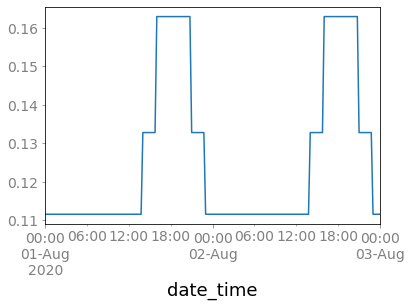

In [18]:
e_price = e_price.truncate(before = start_date, after = final_date+timedelta(days=1))
e_price['e_price'].plot()

### Run simulation

In [20]:
from util.mpc import controller_MPC

import matplotlib.dates as mdates

<AxesSubplot:xlabel='date_time'>

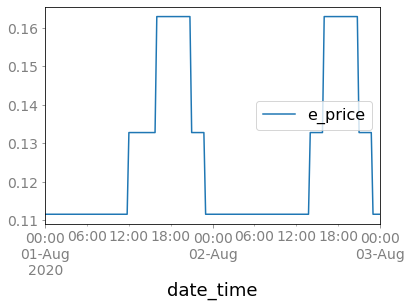

In [51]:
e_price_fake = e_price.copy()
e_price_fake[48:56] = 0.1328
e_price_fake.plot()

In [52]:
T = 12
N = T*4
ePrice = e_price_fake

In [53]:
# Simulate MPC

np.random.seed(1)

obs = env.reset()

controller_mpc = controller_MPC(pars.loc[0, 'R'], pars.loc[0, 'C'], T, N, pars.loc[0, 'Q_c'])

T_in_mpc = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))
Action_mpc = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))
Action_mpc_continuous = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))

for time in T_in_mpc.index:
    t_current = obs[3];
    input_data = env.weatherForecast()[['Temperature']]
    t_eq = env.otherHGForecast().flatten()
    t_eq = np.append(t_eq,t_eq[0])
    input_data['t_eq'] = t_eq
    input_data['t_lower'] = pars.loc[0, 'T_sp'] - pars.loc[0, 'T_range']/2
    input_data['t_upper'] = pars.loc[0, 'T_sp'] + pars.loc[0, 'T_range']/2
    input_data = input_data.resample('15T').interpolate(method='linear')
    input_data = input_data.iloc[:N+1,:]

    action, action_continuous = controller_mpc.action(t_current, 
                                input_data['Temperature'].values,
                                input_data['t_eq'].values,
                                input_data['t_lower'].values,
                                input_data['t_upper'].values,
                                ePrice.loc[input_data.index,'e_price'].values)
    action_list = [action]
    action_continuous_list = [action_continuous]
    
    T_in_mpc.loc[time] = t_current
    Action_mpc.loc[time] = action_list
    Action_mpc_continuous.loc[time] = action_continuous_list
    
    obs,_,_,_ = env.step(np.array(action_list)*2)    # 2 for cooling


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

  40r6.9061806e+000 7.39e-002 1.00e+003  -1.0 0.00e+000    -  0.00e+000 4.49e-007R  5
  41r7.0120247e+000 1.23e-001 9.84e+002  -1.0 1.38e+000    -  1.55e-002 5.84e-002f  1
  42r7.0146085e+000 1.24e-001 9.37e+002  -1.0 3.15e-001    -  9.31e-001 3.17e-003f  2
  43r7.9970109e+000 1.45e-001 1.00e-006  -1.0 5.27e-001    -  1.00e+000 1.00e+000f  1
  44r7.1674249e+000 1.53e-001 4.98e-001  -3.8 2.14e-001    -  9.48e-001 9.89e-001f  1
  45r7.0878715e+000 1.50e-001 1.50e-009  -3.8 1.62e-002    -  1.00e+000 1.00e+000f  1
  46r6.9475565e+000 1.49e-001 1.83e-003  -5.7 1.64e-001    -  9.39e-001 1.00e+000f  1
  47r6.9449407e+000 1.34e-001 1.86e-011  -5.7 1.63e-002    -  1.00e+000 1.00e+000h  1
  48r6.9231817e+000 1.30e-001 9.63e-005  -8.6 7.77e-002    -  8.45e-001 1.00e+000h  1
  49r6.9227449e+000 1.29e-001 2.27e-013  -8.6 2.58e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r6.9142888e+000 1.17e-001 2.27e-013  -8.6 3.79e-002    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

   1 2.5823700e-001 1.44e+001 2.97e+000  -1.0 2.64e+001    -  1.01e-001 4.05e-001f  1
   2 2.6295115e-001 1.43e+001 1.26e+002  -1.0 1.57e+001    -  5.99e-001 6.81e-003h  1
   3 2.6096761e-001 1.43e+001 5.57e+004  -1.0 3.24e+001    -  4.98e-001 1.18e-003h  1
   4 2.6207986e-001 1.43e+001 6.59e+007  -1.0 3.43e+001    -  5.00e-001 4.19e-004h  1
   5r2.6207986e-001 1.43e+001 1.00e+003   1.2 0.00e+000    -  0.00e+000 2.63e-007R  5
   6r3.0216892e-001 1.40e+001 9.99e+002   1.2 9.53e+003    -  2.16e-001 1.36e-004f  1
   7r4.0115802e-001 7.81e+000 9.47e+002   1.2 2.58e+002    -  4.06e-002 5.23e-002f  1
   8 4.0710079e-001 7.79e+000 5.64e+000  -1.0 9.99e+000    -  1.03e-002 2.21e-003h  1
   9 4.0712151e-001 7.79e+000 4.96e+003  -1.0 1.01e+001    -  1.72e-002 2.48e-005h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.0702296e-001 7.79e+000 3.91e+006  -1.0 3.42e+001    -  2.77e-002 3.52e-005h  1
  11r4.0702296e-001 7.79e+000 1.00e+003   0.9 0.00e+000    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

  54 6.3418290e+000 1.97e-002 1.49e-008  -3.8 4.21e-002    -  1.00e+000 1.00e+000s 22
  55 6.3418281e+000 1.97e-002 1.63e-009  -3.8 7.17e-004    -  1.00e+000 1.00e+000s 22
  56r6.3418281e+000 1.97e-002 1.00e+003  -1.7 0.00e+000    -  0.00e+000 0.00e+000R  1
  57r6.4828026e+000 3.42e-002 9.63e+002  -1.7 2.07e+001    -  3.60e-002 1.05e-001f  1
  58r6.5401811e+000 4.91e-002 7.54e+002  -1.7 7.30e+000    -  3.29e-001 1.57e-001f  1
  59r6.7475180e+000 5.45e-002 2.20e+002  -1.7 3.10e+000    -  6.58e-001 8.15e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r8.3537537e+000 5.27e-002 7.06e+001  -1.7 9.01e+000    -  6.80e-001 6.56e-001f  1
  61r8.0721911e+000 4.69e-002 1.97e-007  -1.7 2.92e+000    -  1.00e+000 1.00e+000f  1
  62r7.2182872e+000 4.76e-002 2.18e-001  -3.8 1.37e+000    -  9.12e-001 1.00e+000f  1
  63r7.1642987e+000 4.65e-002 1.46e-009  -3.8 1.01e-001    -  1.00e+000 1.00e+000h  1
  64r6.7401255e+000 4.30e-002 3.48e-003  -5.8 7.12e-001    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

  10 2.1641385e+001 9.83e-006 3.37e-002  -3.8 2.20e+001    -  8.48e-001 7.45e-001f  1
  11 2.1611868e+001 1.49e-005 2.54e-002  -3.8 5.09e+000    -  7.35e-001 9.93e-001f  1
  12 2.1610060e+001 2.12e-006 1.50e-009  -3.8 1.70e+000    -  1.00e+000 1.00e+000f  1
  13 2.1603029e+001 1.41e-006 4.26e-004  -5.7 1.16e+000    -  9.46e-001 9.85e-001f  1
  14 2.1602901e+001 1.05e-007 1.84e-011  -5.7 8.85e-002    -  1.00e+000 1.00e+000f  1
  15 2.1602813e+001 1.44e-008 2.51e-014  -8.6 1.21e-002    -  1.00e+000 1.00e+000h  1
  16 2.1602813e+001 2.09e-011 9.09e-015  -9.0 1.76e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:  2.1602813341759671e+001   2.1602813341759671e+001
Dual infeasibility......:  9.0934204610704228e-015   9.0934204610704228e-015
Constraint violation....:  2.0879298290310544e-011   2.0879298290310544e-011
Complementarity.........:  9.0910184760980151e-010   9.0910184760

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

  14 2.9281992e+001 1.78e-006 1.12e-003  -5.7 1.16e+000    -  9.32e-001 9.92e-001h  1
  15 2.9281875e+001 1.04e-007 1.84e-011  -5.7 8.51e-002    -  1.00e+000 1.00e+000f  1
  16 2.9281785e+001 1.67e-008 2.51e-014  -8.6 1.36e-002    -  1.00e+000 1.00e+000h  1
  17 2.9281785e+001 2.27e-011 9.09e-015  -9.0 1.85e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:  2.9281785211073121e+001   2.9281785211073121e+001
Dual infeasibility......:  9.0934204610704228e-015   9.0934204610704228e-015
Constraint violation....:  2.2723156689608004e-011   2.2723156689608004e-011
Complementarity.........:  9.0911322786337303e-010   9.0911322786337303e-010
Overall NLP error.......:  9.0911322786337303e-010   9.0911322786337303e-010


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations          

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

Number of objective gradient evaluations             = 19
Number of equality constraint evaluations            = 19
Number of inequality constraint evaluations          = 19
Number of equality constraint Jacobian evaluations   = 19
Number of inequality constraint Jacobian evaluations = 19
Number of Lagrangian Hessian evaluations             = 18
Total CPU secs in IPOPT (w/o function evaluations)   =      0.020
Total CPU secs in NLP function evaluations           =      0.049

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        19
       nlp_g  |  12.00ms (631.58us)  11.90ms (626.11us)        19
    nlp_grad  |   3.00ms (  3.00ms)   3.03ms (  3.03ms)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        20
  nlp_hess_l  |        0 (       0)        0 (       0)        18
   nlp_jac_g  |  40.00ms (  2.00ms)  40.13ms (  2.01ms)        20
       total  |  73.00ms ( 

Constraint violation....:  1.6501289223924687e-010   1.6501289223924687e-010
Complementarity.........:  2.5059200551413353e-009   2.5059200551413353e-009
Overall NLP error.......:  2.5059200551413353e-009   2.5059200551413353e-009


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 20
Number of inequality constraint evaluations          = 20
Number of equality constraint Jacobian evaluations   = 20
Number of inequality constraint Jacobian evaluations = 20
Number of Lagrangian Hessian evaluations             = 19
Total CPU secs in IPOPT (w/o function evaluations)   =      0.020
Total CPU secs in NLP function evaluations           =      0.049

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        20
       nlp_g  |   9.00ms (450.00us)   9.01ms (450.60us)        20


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

  18 1.3789330e+001 8.81e-011 2.51e-014  -8.6 3.31e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:  1.3789329959358833e+001   1.3789329959358833e+001
Dual infeasibility......:  2.5063284780912909e-014   2.5063284780912909e-014
Constraint violation....:  8.8057561242749216e-011   8.8057561242749216e-011
Complementarity.........:  2.5059138007440225e-009   2.5059138007440225e-009
Overall NLP error.......:  2.5059138007440225e-009   2.5059138007440225e-009


Number of objective function evaluations             = 19
Number of objective gradient evaluations             = 19
Number of equality constraint evaluations            = 19
Number of inequality constraint evaluations          = 19
Number of equality constraint Jacobian evaluations   = 19
Number of inequality constraint Jacobian evaluations = 19
Number of Lagrangian Hessian evaluations             = 18
Total CPU secs in I

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

  10 6.6670224e+000 1.76e-005 2.83e-008  -2.5 2.06e+000    -  1.00e+000 1.00e+000f  1
  11 6.5957747e+000 1.26e-005 1.59e-001  -3.8 8.33e-001    -  6.69e-001 8.09e-001f  1
  12 6.5638904e+000 1.41e-005 2.97e-002  -3.8 7.40e-001    -  7.21e-001 8.69e-001f  1
  13 6.5597562e+000 4.61e-006 1.50e-009  -3.8 3.46e-001    -  1.00e+000 1.00e+000f  1
  14 6.5543440e+000 2.28e-006 4.75e-003  -5.7 1.44e-001    -  8.98e-001 7.76e-001h  1
  15 6.5527865e+000 5.61e-007 1.84e-011  -5.7 4.18e-002    -  1.00e+000 1.00e+000f  1
  16 6.5527048e+000 3.63e-008 8.69e-007  -8.6 2.72e-003    -  9.95e-001 1.00e+000h  1
  17 6.5527052e+000 6.43e-011 2.66e-014  -8.6 3.86e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:  6.5527052087151008e+000   6.5527052087151008e+000
Dual infeasibility......:  2.6645352591003757e-014   2.6645352591003757e-014
Constraint violation....:  6.4293459445252665e-011   6.4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      145
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       97
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      192
        inequality constraints with only lower bounds:       96
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       96

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

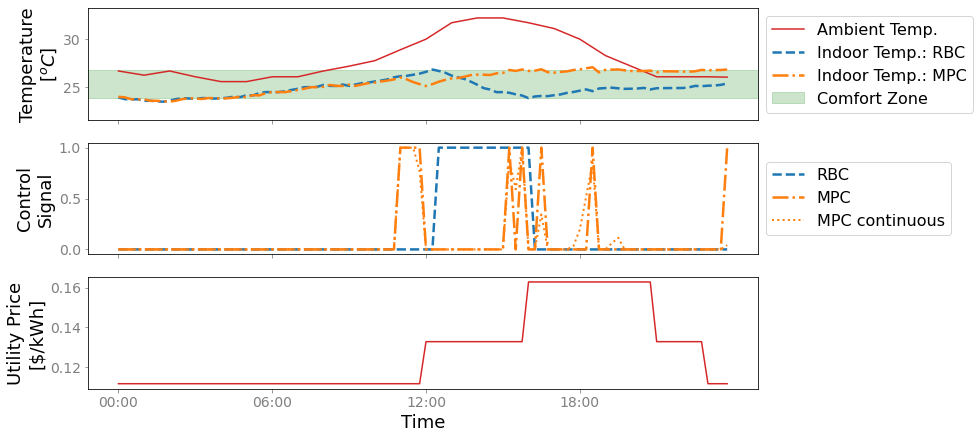

In [85]:
fig, axes = plt.subplots(3,1, figsize=(12, 7), sharex=True)

time_index = T_out.index

# subplot1: temperature
axes[0].plot(time_index, T_out['T_out'].values, color=default_colors[3], label='Ambient Temp.')
# plot deadband
axes[0].axhspan(t_lower, t_upper, color='green', alpha=0.2, label='Comfort Zone')
# axes[0].plot((time_index[0],time_index[-1]), (t_lower, t_lower), 'g--', label='Comfort range')
# axes[0].plot((time_index[0],time_index[-1]), (t_upper, t_upper), 'g--')
# plot temperature
axes[0].plot(time_index, T_in_rbc, '--', color=default_colors[0], linewidth=2.5, label='Indoor Temp.: RBC')
axes[0].plot(time_index, T_in_mpc, '-.', color=default_colors[1], linewidth=2.5, label='Indoor Temp.: MPC')
axes[0].set_ylabel('Temperature\n[$^oC$]')
axes[0].set_ylim(T_out['T_out'].values.min()-4, T_out['T_out'].values.max()+1)
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))

# subplot2: total cooling load
a_rbc = (Action_rbc).sum(axis=1)
a_mpc = (Action_mpc).sum(axis=1)
a_mpc_cont = (Action_mpc_continuous).sum(axis=1)
axes[1].plot(time_index, a_rbc, '--', color=default_colors[0], linewidth=2.5, label='RBC')
axes[1].plot(time_index, a_mpc, '-.', color=default_colors[1], linewidth=2.5, label='MPC')
axes[1].plot(time_index, a_mpc_cont, ':', color=default_colors[1], linewidth=2, label='MPC continuous')
axes[1].set_ylabel('Control\nSignal')
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))

# subplot3: utility price
axes[2].plot(time_index, ePrice['e_price'].values[:96], color=default_colors[3])
axes[2].set_ylabel('Utility Price\n[$/kWh]')

axes[2].set_xlabel('Time')
axes[2].set_xticks(time_index[::24])
myFmt = mdates.DateFormatter('%H:%M')
axes[2].xaxis.set_major_formatter(myFmt)

plt.savefig(generate_fig_name('mpc'))

### Cost analysis

In [63]:
Action_rbc.columns= ['RBC_action']
Action_mpc.columns= ['MPC_action']
cost_analysis = pd.concat([e_price_fake,Action_rbc,Action_mpc],axis=1)

In [67]:
cost_analysis.dropna(inplace=True)
cost_analysis

,e_price,RBC_action,MPC_action
2020-08-01 00:00:00,0.1116,0,0
2020-08-01 00:15:00,0.1116,0,0
2020-08-01 00:30:00,0.1116,0,0
2020-08-01 00:45:00,0.1116,0,0
2020-08-01 01:00:00,0.1116,0,0
...,...,...,...
2020-08-01 22:45:00,0.1328,0,0
2020-08-01 23:00:00,0.1116,0,0
2020-08-01 23:15:00,0.1116,0,0
2020-08-01 23:30:00,0.1116,0,0


In [71]:
(cost_analysis['e_price']*cost_analysis['RBC_action']).values.sum()

2.0221

In [72]:
(cost_analysis['e_price']*cost_analysis['MPC_action']).values.sum()

1.1494